--- 
## 1. Introduction

In this tutorial, we will have a look at the practical side of the Conjugate Gradients method that was introduced this morning. We will explore the general approach and its limitations further, as well as some issues that can arise and how to get around them with preconditioners.

As a small reminder, we want to solve equations of the form

$$
Ax = b,
$$

where $A \in \mathbb{R}^{(n \times n)}$ is a **symmetric** and **positive-definite** matrix. This property allows us to view the problem as a minimization problem, namely

$$
f(x) = \frac 1 2 x^T A x - b^T x,
$$

which is central to the CG method. But let's look at direct methods to this problem first.

### 1.1. Setup

First, we import the necessary libraries. We'll be using `numpy` for numerical operations and `matplotlib` for plotting.

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np

# Set up plotting style
plt.style.use("seaborn-v0_8-whitegrid")

### 1.2. Generate an Example Problem

As mentioned before, the CG method requires the matrix $A$ to be symmetric and positive-definite. A simple way to generate such a matrix is to create a random matrix $M$ and compute $A = M^T M$. This construction guarantees that $A$ is symmetric and positive semi-definite. If $M$ is non-singular, $A$ will be positive-definite.

We will set up a linear system $Ax = b$ where we know the true solution `x_true` beforehand. This allows us to easily verify the correctness of our implementations.

In [2]:
# A = np.array([[2, 1], [-1, 0]])
# B = np.array([[0, 0.2], [-4, 1]])
# A @ B

In [3]:
def generate_spd_matrix(n):
    """Generates a symmetric positive-definite matrix of size n x n."""
    M = np.random.rand(n, n)
    # Ensure M is well-conditioned enough to be non-singular
    M += np.eye(n)
    A = M.T @ M
    return A


# Define the size of our problem. Feel free to try a few different values during the course of this exercise.
n = 5

A = generate_spd_matrix(n)
print(A)
x_true = np.random.rand(n)
print(x_true)
# Calculate the right-hand side b
b = A @ x_true

print(
    f"Generated a {A.shape[0]}x{A.shape[1]} symmetric, positive-definite matrix A and vector b."
)

[[4.03310973 2.48541666 2.17431292 2.34308515 2.76339725]
 [2.48541666 2.73684073 0.88530747 1.70201571 2.09630476]
 [2.17431292 0.88530747 2.29574733 1.20163873 1.89228475]
 [2.34308515 1.70201571 1.20163873 2.30426447 2.0509798 ]
 [2.76339725 2.09630476 1.89228475 2.0509798  3.82180544]]
[0.16312924 0.96288522 0.92119761 0.10000806 0.3901059 ]
Generated a 5x5 symmetric, positive-definite matrix A and vector b.


### 1.3. The "Naive" Approach: Direct Solver

Before diving into iterative methods, let's solve the system using a standard direct solver from NumPy, `np.linalg.solve`. This function typically uses an LU decomposition, which is very accurate and robust for small to moderately sized dense matrices.

In [4]:
print("Solving Ax = b using the direct method (np.linalg.solve)...")

# Time the direct solver
start_time = time.time()
x_naive = np.linalg.solve(A, b)
end_time = time.time()

time_naive = end_time - start_time

# Check the error
error_naive = np.linalg.norm(x_naive - x_true) / np.linalg.norm(x_true)

print(f"Direct solver finished in {time_naive:.4f} seconds.")
print(f"Relative error of the solution: {error_naive:.2e}")

Solving Ax = b using the direct method (np.linalg.solve)...
Direct solver finished in 0.0002 seconds.
Relative error of the solution: 5.40e-16


This gives us a baseline for both speed and accuracy. For a 1000x1000 matrix, the direct solver should be quite fast, but as we scale up, its computational cost ($O(n^3)$) and memory requirements ($O(n^2)$) will become significant.

### 1.4. The Idea behind the Conjugate Gradient Method

The CG method combines the concept of **steepest descent** with **Krylow subspaces**:

First, we start at some initial point $x_0$, and take a step in the direction of steepest descent.

- This step takes place in the first, one-dimensional Krylow-subspace
- Ideally, this step takes us the optimal amount of length along that direction

Then, for each further step, we find the new direction of maximum descent, but we *only consider directions that do not undo previous progress*

- This means that the steps are $A$-conjugate, instead of merely being orthogonal
- The dimension of the Krylow-subspace increases with each step, so we require at most $n$ steps

This approach gives us the exact solution after at most $n$ steps, if we have perfect arithmetic. While we cannot assume this in practice, much fewer steps can give a good approximation.

### 1.5. The Conjugate Gradient Algorithm (Pseudo-code)

Now let's look at the algorithm we want to implement. The goal is to find $x$ that minimizes $\frac{1}{2}x^T A x - x^T b$.

Given the system $Ax=b$, an initial guess $x_0$, a tolerance `tol`, and a maximum number of iterations `max_iter`:

1.  **Initialize**
    -   $r_0 = b - Ax_0$
    -   $p_0 = r_0$
    -   $k = 0$

2.  **Iterate** while $k < \text{maxiter}$ and $\|r_k\| > \text{tol}$:
    -   $\alpha_k = \frac{r_k^T r_k}{p_k^T A p_k}$
    -   $x_{k+1} = x_k + \alpha_k p_k$
    -   $r_{k+1} = r_k - \alpha_k A p_k$
    -   $\beta_k = \frac{r_{k+1}^T r_{k+1}}{r_k^T r_k}$
    -   $p_{k+1} = r_{k+1} + \beta_k p_k$
    -   $k = k + 1$

3. **Return** $x_k$

**Key variables:**
- `x`: The solution vector, which we are improving in each step.
- `r`: The residual vector ($r = b - Ax$), which we can use to compute the current error.
- `p`: The search direction vector. Note that we always move along the residual, here we choose special "$A$-orthogonal" directions.
- `alpha`: The step size.
- `beta`: The improvement factor for the next search direction.

--- 
## 2. Exercise: CG Implementation

### 2.1. Implementing the Algorithm

Now it's your turn! Fill in the missing lines in the `conjugate_gradient` function below. Follow the pseudo-code from the previous section. 

**Hint:** The term $r_k^T r_k$ appears multiple times. It's efficient to compute it once per iteration and reuse the value.

In [5]:
def conjugate_gradient(A, b, x0=None, tol=1e-6, max_iter=1000):
    """
    Solves the system Ax = b using the Conjugate Gradient method.

    Args:
        A (np.ndarray): The n x n symmetric positive-definite matrix.
        b (np.ndarray): The n x 1 right-hand side vector.
        x0 (np.ndarray, optional): Initial guess for the solution. Defaults to a zero vector.
        tol (float, optional): The tolerance for convergence.
        max_iter (int, optional): The maximum number of iterations.

    Returns:
        tuple: A tuple containing:
            - x (np.ndarray): The solution vector.
            - residuals (list): A list of the residual norm at each iteration.
    """
    n = len(b)

    # Initialize solution vector x
    if x0 is None:
        x = np.zeros(n)
    else:
        x = x0

    # ---- TODO: Initialize r, p, and rs_old ---- #
    # r is the residual
    # p is the search direction
    # rs_old is the dot product of the residual with itself
    r = b - (A @ x)
    p = r.copy()
    rs_old = r.T @ r
    # -------------------------------------------- #

    residuals = [np.sqrt(rs_old)]

    if residuals[0] < tol:
        print("Initial guess is already within tolerance.")
        return x, residuals

    for i in range(max_iter):
        # ---- TODO: Main CG iteration steps ---- #

        # 1. Calculate Ap = A * p
        Ap = A @ p

        # 2. Calculate step size alpha
        alpha = rs_old / (p.T @ Ap)

        # 3. Update solution
        x = x + alpha * p

        # 4. Update residual
        r = r - alpha * Ap

        # 5. Calculate new residual norm squared
        rs_new = r.T @ r

        # ------------------------------------- #

        # Check for convergence
        residual_norm = np.sqrt(rs_new)
        residuals.append(residual_norm)
        if residual_norm < tol:
            print(f"Converged after {i + 1} iterations.")
            break

        # ---- TODO: Update search direction ---- #
        p = r + (rs_new / rs_old) * p
        rs_old = rs_new
        # ------------------------------------- #
    else:
        print(f"Did not converge within {max_iter} iterations.")

    return x, residuals

### 2.2. Test your Implementation

Let's run your implementation, check that it works, and see how it performs compared to the direct solver.

**Don't worry if the code does not seem to converge**, it is quite possible that you will have errors around e-2, even if you implemented everything correctly.

In [6]:
# (Optional): Play around with n and tol a little and see what happens
n = 6
tol = 1.0e-6

A = generate_spd_matrix(n)

# As a sanity-check, you can also see if your code converges in the trivial case of A = Id
# A = np.eye(n)

x_true = np.random.rand(n)

# Calculate the right-hand side b
b = A @ x_true

print(
    f"Generated a {A.shape[0]}x{A.shape[1]} symmetric, positive-definite matrix A and vector b."
)

Generated a 6x6 symmetric, positive-definite matrix A and vector b.


In [7]:
# (Optional): Run the naive solver again, for time comparisons
print("Solving Ax = b using the direct method (np.linalg.solve)...")

# Time the direct solver
start_time = time.time()
x_naive = np.linalg.solve(A, b)
end_time = time.time()

time_naive = end_time - start_time

# Check the error
error_naive = np.linalg.norm(x_naive - x_true) / np.linalg.norm(x_true)

print(f"Direct solver finished in {time_naive:.4f} seconds.")
print(f"Relative error of the solution: {error_naive:.2e}")

Solving Ax = b using the direct method (np.linalg.solve)...
Direct solver finished in 0.0001 seconds.
Relative error of the solution: 1.58e-14


In [8]:
print("Solving Ax = b using our own CG implementation...")

# Time the CG solver
start_time = time.time()
x_cg, residuals_cg = conjugate_gradient(A, b, tol=tol, max_iter=n)
end_time = time.time()

time_cg = end_time - start_time

# Check the error
error_cg = np.linalg.norm(x_cg - x_true) / np.linalg.norm(x_true)

print(f"\nCG solver finished in {time_cg:.4f} seconds.")
print(f"Relative error of the solution: {error_cg:.2e}")
print(f"Final residual norm: {residuals_cg[-1]:.2e}")

print(f"\n--- Comparison so far ---")
print(f"Direct solver time: {time_naive:.4f} s")
print(f"Simple CG time:     {time_cg:.4f} s")

Solving Ax = b using our own CG implementation...
Converged after 6 iterations.

CG solver finished in 0.0002 seconds.
Relative error of the solution: 9.62e-11
Final residual norm: 1.88e-09

--- Comparison so far ---
Direct solver time: 0.0001 s
Simple CG time:     0.0002 s


**What is happening?**

-   Is the result correct? (Compare `error_cg` to `error_naive` from earlier).
-   How does the computation time compare?
-   How many iterations did it take to converge? Did it converge at all?

Let's plot the convergence history to see how the residual norm decreases over time.

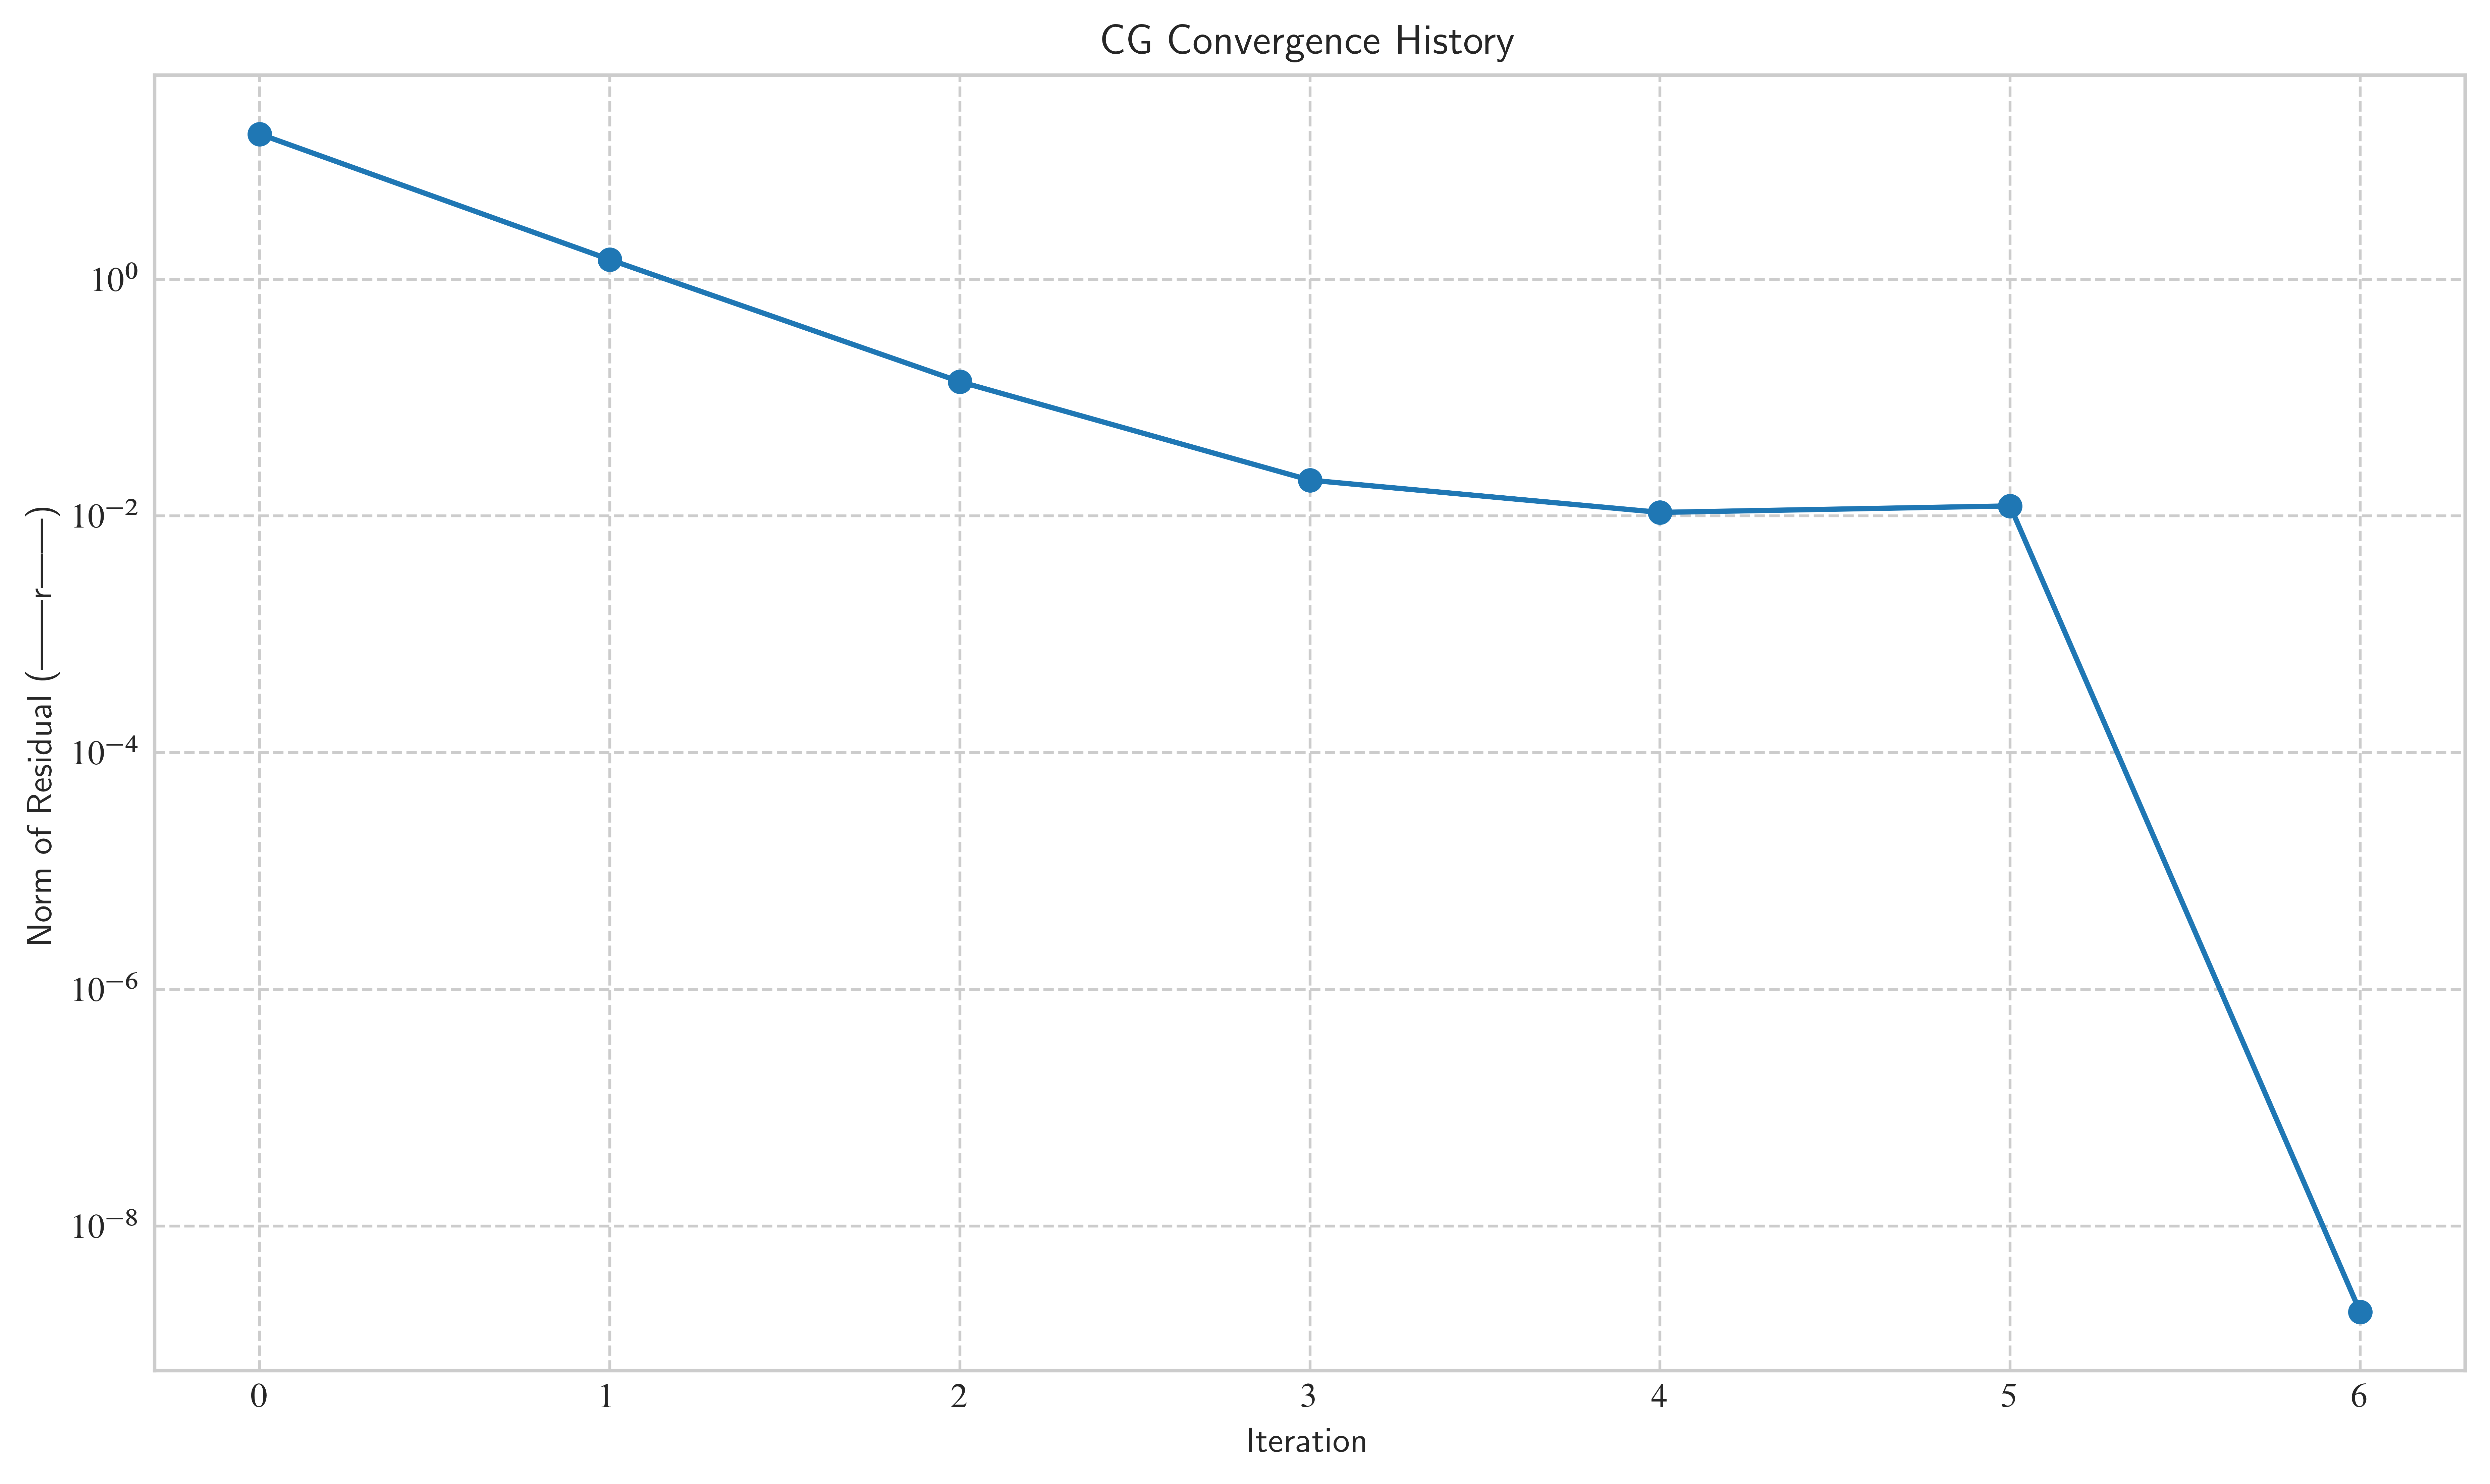

In [9]:
plt.figure(figsize=(10, 6))
plt.semilogy(residuals_cg, marker="o", linestyle="-")
plt.title("CG Convergence History")
plt.xlabel("Iteration")
plt.ylabel("Norm of Residual (||r||)")
plt.grid(True, which="both", ls="--")
plt.show()

You will probably notice some things with your implementation:

1. The direct solver is usually way faster:

- For one, CG's strength lies in very large and/or sparse matrices.
- Even more importantly, the CG method often converges in much fewer than the $n$ steps in practice
- As long as our implementation does not converge at most of the time, it is nowhere near as efficient as it could be! 

2. For any non-trivial example ($n > 10$) and reasonable error tolerances, the algorithm may not converge: You can see in the plot, that the method has a hard time getting below an error tolerance of 1.e-2.
3. The algorithm is not guaranteed to converge after $n$ steps (you can check this by setting `max-iter` to a value higher than `n`): Again, this is due to the lack of perfectly accurate arithmetic.

As you can see, the method is a lot worse than we would have hoped. In the second part of this exercise, we will take a look at preconditioners to speed up convergence and improve these results.

### Bonus exercise

If you are finished before the break, have a think about how we could verify our assumption, before implementing preconditioning. Are there some easy ways to modify the construction of $A$ (i.e. our `generate_spd_matrix` method) to make sure it is well-conditioned?